In [1]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_pdf import PdfPages

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from psth.psth_analysis import set_plot_format, plot_vertical_lines

# Import Data

In [3]:
data_type = 'pca'
algorithm_type = 'gmm'

In [4]:
# working_directory = pathlib.Path(__file__).parent.absolute()
directory = r'C:\Users\shirahad\Documents\research\electrophysiology\analyze_electrophysiology_data\clustering\files' 

In [5]:
nd = '1_0'

In [ ]:
histogram_data_files = ['dec31_seq2_aligned_interpolated_histogram_data.csv',
 'feb23_seq1_aligned_interpolated_histogram_data.csv',
 'feb23_seq2_aligned_interpolated_histogram_data.csv',
 'jan07_seq1_aligned_interpolated_histogram_data.csv',
 'nov08_seq1_aligned_interpolated_histogram_data.csv',
 'nov08_seq2_aligned_interpolated_histogram_data.csv',
 'oct22_seq1_aligned_interpolated_histogram_data.csv',
 'oct29_seq1_aligned_interpolated_histogram_data.csv',
 'oct29_seq2_aligned_interpolated_histogram_data.csv']

In [ ]:
clusters_coordinates_files = ['dec31_seq2_clusters_coordinates.csv',
 'feb23_seq1_clusters_coordinates.csv',
 'feb23_seq2_clusters_coordinates.csv',
 'jan07_seq1_clusters_coordinates.csv',
 'nov08_seq1_clusters_coordinates.csv',
 'nov08_seq2_clusters_coordinates.csv',
 'oct22_seq1_clusters_coordinates.csv',
 'oct29_seq1_clusters_coordinates.csv',
 'oct29_seq2_clusters_coordinates.csv']

In [ ]:
histogram_data_files = ['CONTROL5_L_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL5_R_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL6_L_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL6_R_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL7_L_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL7_R_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL8_L_aligned_interpolated_histogram_data_0.csv']

In [ ]:
clusters_coordinates_files = ['CONTROL5_L_clusters_coordinates_2.csv',
                           'CONTROL5_R_clusters_coordinates_1.csv',
                           'CONTROL6_L_clusters_coordinates_2.csv',
                           'CONTROL6_R_clusters_coordinates_1.csv',
                           'CONTROL7_L_clusters_coordinates_2.csv',
                           'CONTROL7_R_clusters_coordinates_1.csv',
                           'CONTROL8_L_clusters_coordinates_2.csv']

In [6]:
histogram_data_files = ['CONTROL3_R_aligned_interpolated_histogram_data_0.csv',
                       'CONTROL4_L_aligned_interpolated_histogram_data_0.csv']

clusters_coordinates_files = ['CONTROL3_R_clusters_coordinates.csv',
                             'CONTROL4_L_clusters_coordinates_3.csv']

In [7]:
clustering_data_file = 'clustering_data.csv'

In [8]:
def load_mean_data(directory, filename):
    if filename is not None:
        return pd.read_csv(os.path.join(directory, filename), header=0, index_col=0)
    return pd.DataFrame()

In [9]:
def get_intensity_data(data_df, nd):
    idx = pd.IndexSlice
    intensity_data = data_df.loc[:, idx[:, nd, :]]
    intensity_data.columns = intensity_data.columns.droplevel('nd')
    return intensity_data

In [10]:
def get_mean_data(data_df):
    clusters_ids = data_df.columns.get_level_values(0).unique()
    mean_df = pd.DataFrame(np.nan, index=np.arange(0, len(data_df)), columns=clusters_ids)
    mean_df = mean_df.apply(lambda x: data_df[x.name].mean(axis=1).reset_index(drop=True))
    mean_df.index = mean_df.index.map(str)
    return mean_df

# PCA

In [11]:
def normalize(data_df):
    sc = StandardScaler()
    normalized_data = sc.fit_transform(data_df)
    return normalized_data

In [12]:
def get_components_and_score_by_percent(data, percent):
    pca = PCA()
    pca_data = pca.fit_transform(data)
    cumsum_explained_variance = pca.explained_variance_ratio_.cumsum()
    components_number = (np.abs(cumsum_explained_variance - percent)).argmin() + 1 # components that cover percent of the data
    return components_number, pca.components_[: components_number]

In [13]:
def get_weighted_data(data, components_number):
    pca = PCA(n_components=components_number)
    pca_data = pca.fit_transform(data)
    std_pca = np.std(pca_data)
    weighted_data = data * std_pca
    return weighted_data

In [14]:
def remove_substr(string, substr):
    if substr and substr in string:
        return string[: string.find(substr)]
    return string

In [15]:
def get_channels(histogram_file, clusters_coordinates_files, directory, histogram_file_substr='aligned_interpolated_histogram_data'):
    prefix = remove_substr(histogram_file, histogram_file_substr)
    clusters_coordinates_file = [x for x in clusters_coordinates_files if x.startswith(prefix)][0]
    clusters_channel_df = pd.read_csv(os.path.join(directory, clusters_coordinates_file), header=0, index_col=0)
    clusters_channel_df.index = clusters_channel_df.index.map(str)
    clusters_channel_df['prefix'] = prefix
    return clusters_channel_df[['x', 'y', 'z', 'prefix']]

In [16]:
mean_df = load_mean_data(directory, clustering_data_file)

for histogram_file in histogram_data_files:
    data_df = pd.read_csv(os.path.join(directory, histogram_file), header=[0, 1, 2], index_col=0)
    intensity_data = get_intensity_data(data_df, nd)
    clusters_channel_df = get_channels(histogram_file, clusters_coordinates_files, directory)
    mean_data_df = get_mean_data(intensity_data).T
    mean_data_df = mean_data_df.join(clusters_channel_df, how='inner')
    mean_df = mean_data_df if mean_df.empty else mean_df.append(mean_data_df)

In [17]:
normalized_data = normalize(mean_df.drop(columns=['x', 'y', 'z', 'prefix']).T) if clustering_data_file is None else normalize(mean_df.drop(columns=['x', 'y', 'z', 'cluster', 'prefix']).T)

In [18]:
clusters_channel_df

,x,y,z,prefix
id,,,,
7,4812.0,2820.973400,6884.117647,CONTROL4_L_
8,4811.0,2777.706936,6884.117647,CONTROL4_L_
11,4811.0,2777.706936,6884.117647,CONTROL4_L_
12,4811.0,2777.706936,6884.117647,CONTROL4_L_
15,4879.0,2691.174010,6884.117647,CONTROL4_L_
17,4879.0,2691.174010,6884.117647,CONTROL4_L_
19,4879.0,2691.174010,6884.117647,CONTROL4_L_
21,4877.0,2604.641084,6884.117647,CONTROL4_L_
23,4836.0,2561.374620,6884.117647,CONTROL4_L_


In [19]:
partial_normalized_data = normalize(mean_df.drop(columns=['x', 'y', 'z', 'prefix']).T[10 : -10]) if clustering_data_file is None else normalize(mean_df.drop(columns=['x', 'y', 'z', 'cluster', 'prefix']).T[10 : -10])

In [20]:
components_number, data_after_pca = get_components_and_score_by_percent(partial_normalized_data, 0.95)

In [21]:
weighted_data = get_weighted_data(data_after_pca, components_number)

# Gaussian Mixture

In [22]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [23]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    return labels

# More functionality

In [24]:
def get_clusters_groups(data_df, clusters):
    clusters_df = data_df.copy()
    clusters_df['cluster'] = clusters
    cluster_groups = clusters_df.groupby(['cluster'])
    return cluster_groups

# Num of clusters

In [25]:
def select_best(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [26]:
def num_of_clusters_iteration(data, clusters_range, iterations = 50):
    bics = []
    bics_err = []

    for n in clusters_range:
        tmp_bic = []
        for _ in range(iterations):
            gmm = GaussianMixture(n, 
                                  n_init=10, 
                                  covariance_type='diag', 
                                  tol=1e-15,
                                  max_iter=1000,
                                  reg_covar=0.001,
                                  random_state=0
                                 ).fit(data) 
            tmp_bic.append(gmm.bic(data))

        val = np.mean(select_best(np.array(tmp_bic), int(iterations / 5)))
        err = np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)
    return bics, bics_err

In [27]:
n_clusters = np.arange(2, 10)
bics, bics_err = num_of_clusters_iteration(data_after_pca.T, n_clusters)

In [28]:
pdf = PdfPages("{}/measurements_plots.pdf".format(directory))

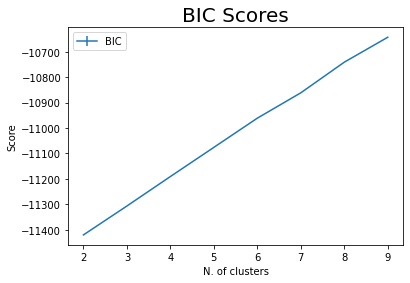

In [29]:
plt.errorbar(n_clusters, bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()
pdf.savefig(plt.gcf())

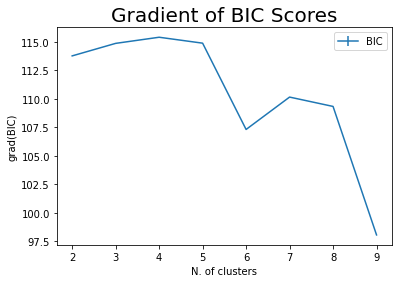

In [30]:
gradients = np.gradient(bics)
plt.errorbar(n_clusters, gradients, yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()
pdf.savefig(plt.gcf())

In [31]:
gradiends_df = pd.DataFrame(gradients, columns=['gradients'])
gradiends_df['num_of_clusters'] = n_clusters
gradiends_df

,gradients,num_of_clusters
0,113.760665,2
1,114.858694,3
2,115.395921,4
3,114.876047,5
4,107.307188,6
5,110.147114,7
6,109.327032,8
7,98.057236,9


In [32]:
gradiends_df.to_csv(r'{}\gradients_data.csv'.format(directory), sep=',', encoding='utf-8')

In [33]:
aligned_bic = bics - min(bics)
exp_aligned_bic = np.exp(-0.5 * aligned_bic)
weighted_aligned_bic = exp_aligned_bic / sum(exp_aligned_bic)

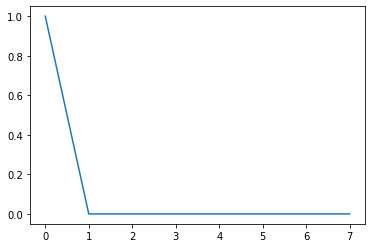

In [34]:
weighted_aligned_bic
plt.plot(weighted_aligned_bic)
pdf.savefig(plt.gcf())

In [35]:
pdf.close()

In [36]:
max_slope_index = np.argmax(abs(gradients[:-1] - gradients[1:]))
max_slope_index

6

In [37]:
min_bic_index = np.argmin(bics)
min_bic_index

0

In [38]:
max_weighted_aligned_bic_index = np.argmax(weighted_aligned_bic)
max_weighted_aligned_bic_index

0

In [50]:
num_of_clusters = n_clusters[max_slope_index]
num_of_clusters = 6

# Calculations

In [51]:
gmm = GaussianMixture(n_components=num_of_clusters, 
                      n_init=10,
                      covariance_type='diag', 
                      tol=1e-15,
                      max_iter=1000,
                      reg_covar=0.001,
                      random_state=0)
fitted = gmm.fit(data_after_pca.T)
labels = fitted.predict(data_after_pca.T)

In [52]:
mean_df['cluster'] = labels

In [53]:
labels

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 1,
       5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 2, 5, 5, 5, 5, 5,
       3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 5, 1, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 2, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 1, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 3, 2, 5, 5, 5, 2,
       5, 5, 5, 5, 5, 0, 2, 1, 0, 5, 5, 5, 1, 5, 1, 1, 5, 0, 5, 5, 5, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5,
       2, 5, 5, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [54]:
mean_df.to_csv(r'{}\clustering_data.csv'.format(directory), sep=',', encoding='utf-8')

In [55]:
normalized_df = pd.DataFrame(normalized_data.T, index=mean_df.index)
clusters_groups = get_clusters_groups(normalized_df, labels)

In [56]:
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
id,,,,,,,,,,,,,,,,,,,,,
16,0.722522,0.564011,0.405499,0.246988,0.088477,-0.121024,-0.559978,-0.998932,-1.437886,-1.876840,...,-0.902495,-0.939074,-0.975654,-1.012233,-1.048813,-1.041053,-1.016667,-0.992281,-0.967894,-0.943508
22,0.194680,-0.177173,-0.549025,-0.920878,-1.292731,-1.601922,-1.629130,-1.656339,-1.683548,-1.710757,...,0.244151,0.198803,0.153455,0.108107,0.062759,0.050391,0.050391,0.050391,0.050391,0.050391
27,-1.237395,-1.157497,-1.077599,-0.997701,-0.917803,-0.824992,-0.674073,-0.523154,-0.372236,-0.221317,...,-1.633254,-1.593305,-1.553356,-1.513407,-1.473458,-1.414140,-1.347558,-1.280976,-1.214394,-1.147813
41,-0.804868,-0.954705,-1.104542,-1.254379,-1.404217,-1.508648,-1.408757,-1.308866,-1.208974,-1.109083,...,-0.959750,-0.882057,-0.804364,-0.726671,-0.648977,-0.643932,-0.666130,-0.688328,-0.710526,-0.732725
44,0.853456,0.694992,0.536527,0.378063,0.219599,0.068992,-0.046255,-0.161502,-0.276748,-0.391995,...,-1.345400,-0.711543,-0.077686,0.556172,1.190029,1.362899,1.362899,1.362899,1.362899,1.362899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.528286,0.446704,0.365122,0.283539,0.201957,0.152513,0.247693,0.342872,0.438051,0.533231,...,-2.079876,-1.889517,-1.699158,-1.508800,-1.318441,-1.048972,-0.749837,-0.450702,-0.151566,0.147569
115,-2.328752,-1.933399,-1.538047,-1.142694,-0.747342,-0.475216,-0.757610,-1.040005,-1.322400,-1.604795,...,0.497477,0.541405,0.585333,0.629261,0.673189,0.402205,0.013127,-0.375950,-0.765027,-1.154104
153,-0.265853,-0.302865,-0.339878,-0.376890,-0.413903,-0.475911,-0.650398,-0.824885,-0.999373,-1.173860,...,0.687339,0.507564,0.327789,0.148014,-0.031761,-0.173081,-0.299981,-0.426881,-0.553781,-0.680681


In [57]:
clusters_mean_df = clusters_groups.mean()
clusters_sem_df = clusters_groups.sem().fillna(0)
groups_sizes = clusters_groups.size()

In [58]:
def get_data_points(rep_duration = 10, pre = 3, post = 6):
    bins_num = rep_duration + (pre + 1) + (post + 1) + 1
    data_points_num = bins_num * 5 - 1
    data_points = np.linspace(0, bins_num, data_points_num)
    data_points = data_points[np.where((data_points > 1) & (data_points < bins_num - 2))]
    aligned_data_points = np.subtract(data_points, 1)
    return aligned_data_points

data_points = get_data_points()

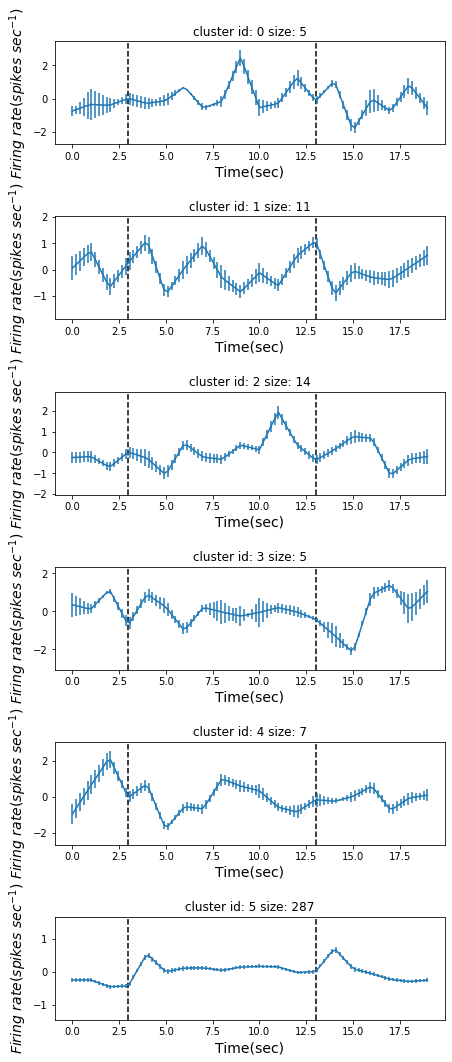

In [59]:
rows_num = num_of_clusters
cols_num = 1
fig, axes = plt.subplots(figsize=((rows_num + 1), cols_num * 18), nrows=rows_num, ncols=cols_num, gridspec_kw=dict(hspace=0.7, wspace=0.3))

for (index, row), ax in zip(clusters_mean_df.iterrows(), axes):
    ax.set_ylim(row.min() - 1, row.max() + 1)
    plot_vertical_lines(ax)
    ax.errorbar(data_points, row, clusters_sem_df.T[index])
    set_plot_format(ax, index, 'Time(sec)', '$Firing\ rate(spikes\ sec^{-1})$')
    ax.set_title('cluster id: {} size: {}'.format(index, groups_sizes[index]))
    plots_filename = r'{}\clusters_mean_response_plots.pdf'.format(directory)
    plt.savefig(plots_filename, bbox_inches='tight') # save plots

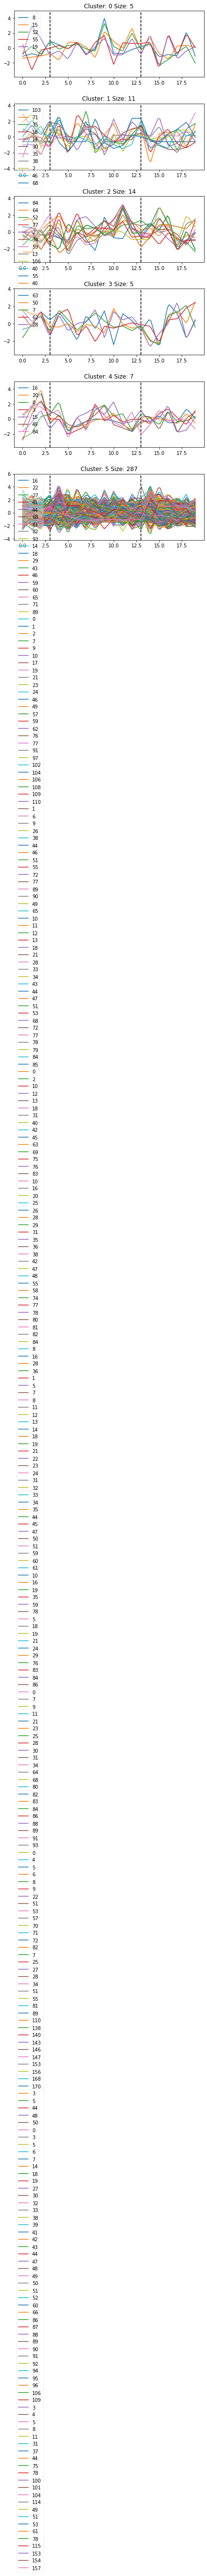

In [60]:
fig, axes = plt.subplots(figsize=((rows_num + 1), cols_num * 20), nrows=rows_num, ncols=cols_num, gridspec_kw=dict(hspace=0.4, wspace=0.3))

for (key, group), ax in zip(clusters_groups, axes.flatten()):
    ax.set_ylim(group.min().min() - 1, group.max().max() + 1)
    plot_vertical_lines(ax)
    group = group.drop(columns=['cluster'])
    group.columns = data_points
    group.T.plot(ax=ax, title='Cluster: {} Size: {}'.format(key, groups_sizes[key]))
    ax.legend(fontsize='medium', loc='upper left', framealpha=0.3)
    plots_filename = r'{}\clusters_responses_plots.pdf'.format(directory)
    plt.savefig(plots_filename, bbox_inches='tight') # save plots
    

In [61]:
for (key, group) in clusters_groups:
    print(group)

           0         1         2         3         4         5         6  \
id                                                                         
8  -1.122783 -1.046386 -0.969990 -0.893593 -0.817196 -0.766596 -0.832079   
15 -1.384395 -1.352046 -1.319696 -1.287347 -1.254998 -1.222649 -1.190300   
52 -0.819224 -0.600181 -0.381138 -0.162095  0.056948  0.194608 -0.033959   
55  0.447647 -0.264344 -0.976334 -1.688324 -2.400315 -2.883273 -2.335588   
19 -0.861314 -0.067857  0.725600  1.519057  2.312514  2.899878  2.559825   

           7         8         9  ...        85        86        87        88  \
id                                ...                                           
8  -0.897562 -0.963044 -1.028527  ...  0.013246  0.678990  1.344733  2.010476   
15 -1.157950 -1.125601 -1.093252  ...  0.288943  0.310509  0.332075  0.353641   
52 -0.262526 -0.491092 -0.719659  ... -0.324862 -0.153437  0.017988  0.189413   
55 -1.787903 -1.240218 -0.692534  ...  0.004520  0.570461  1.1